In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import os
import re

from IPython.display import clear_output

%matplotlib inline

------
<a id="indice"></a>

# Índice

1. **[Coleta](#coleta)**
    * [Twitter Archive](#coleta:twitter-archive)
    * [Image Prediction](#coleta:image-prediction)
    * [Twitter API](#coleta:twitter-api)
    
    
2. **[Avaliação](#avaliacao)**
    * [Twitter Archive](#avaliacao:twitter-archive)
    * [Image Prediction](#avaliacao:image-prediction)
    * [Twitter API](#avaliacao:twitter-api)
    * [Notas da avaliação](#avaliacao:anotacoes)
    
    
3. **[Limpeza](#limpeza)**
    * [Definição](#limpeza:definicao)
    * [Twitter Archive](#limpeza:twitter-archive)
    * [Image Prediction](#limpeza:image-prediction)
    * [Twitter API](#limpeza:twitter-api)
    
    
4. **[Master dataframe](#master-dataframe)**


5. **[Armazenamento](#armazenamento)**


6. **[Insights](#insights)**

------
<a id="coleta"></a>

# Coleta

<a id="coleta:twitter-archive"></a>

## Coleta: Twitter archive

In [2]:
df_twitter_arc = pd.read_csv('data/twitter-archive-enhanced.csv')
df_twitter_arc.sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
563,802572683846291456,NaN,NaN,2016-11-26 18:00:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Winnie. She's h*ckin ferocious. Dandel...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/802572683...,12,10,Winnie,None,None,None,None
320,834458053273591808,NaN,NaN,2017-02-22 17:41:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Chester (bottom) &amp; Harold (top). They...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/834458053...,12,10,Chester,None,None,None,None


<a id="coleta:image-prediction"></a>

## Coleta: Image prediction

In [3]:
df_prediction = None

r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

if r.status_code is 200:
    df_prediction = pd.read_csv(pd.compat.StringIO(r.text), sep='\t')    
else:    
    print('ERROR: Image prediction request returned {status_code} status code.'.format(status_code = r.status_code))

In [4]:
df_prediction.sample(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
965,706265994973601792,https://pbs.twimg.com/media/Cc0pLU0WAAEfGEw.jpg,1,papillon,0.743715,True,Pekinese,0.114042,True,Saint_Bernard,0.047715,True
1378,764259802650378240,https://pbs.twimg.com/media/CpsyNtXWgAAqvs3.jpg,1,German_shepherd,0.973677,True,malinois,0.025950,True,kelpie,0.000192,True


In [5]:
df_prediction.to_csv('data/image_predictions.tsv')

<a id="coleta:twitter-api"></a>

## Coleta: Twitter API

In [6]:
# Carregar configuração do Twitter App
with open('twitter_config.json', 'r', encoding='utf-8') as file:
    app_config = json.load(file)

In [7]:
# Atribuição da configurações a variaveis locais
api_key = app_config['api_key']
api_secret = app_config['api_secret']
access_token = app_config['access_token']
access_secret = app_config['access_secret']

In [8]:
# Autentificação ao Twitter App
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Buscar dados do histórico de Tweets na API

In [9]:
json_path = 'data/tweet_json.txt'
error_log = 'data/tweet_error.log'

# Salvar Tweets localmente
if(not os.path.isfile(json_path)):
    print('Aguarde. Dado o volume de requisições, a coleta de tweets pode demorar alguns minutos.')
    tweet_count = 0
    for tweet_id in df_twitter_arc.tweet_id:
        print('{percent}%'.format(percent=int((++tweet_count/df_twitter_arc.tweet_id.size)*100)))
        try:
            status = api.get_status(tweet_id)
            with open(json_path, 'a', newline='\n') as file:
                file.write(f'{json.dumps(status._json)}\n')

        except Exception as err:
            with open(error_log, 'a', newline='\n') as log:
                log.write(f'{str(tweet_id)}: {str(err.args[0])}\n')
            print(f'{str(tweet_id)}: {str(err.args[0])}')
        
        clear_output(wait=True)
else:
    print('Dados já salvos em disco, não serão executadas novas requisições à API do Twitter.')
        

Dados já salvos em disco, não serão executadas novas requisições à API do Twitter.


In [10]:
# Criar uma lista de Dictionaries com os Tweets carregados
tweets = []

with open(json_path, 'r') as file:
    for line in file:
        try:
            tweet = json.loads(line)
            
            if(tweet.get('entities', False)):
                if(tweet['entities'].get('media', False) and tweet['entities']['media'][0].get('media_url', False)):
                    tweets.append({
                        'id': int(tweet['id']),
                        'created_at': tweet['created_at'],
                        'in_reply_to_status_id': str(tweet['in_reply_to_status_id']),
                        'in_reply_to_user_id': str(tweet['in_reply_to_user_id']),
                        'is_quote_status': tweet['is_quote_status'],
                        'retweet_count': int(tweet['retweet_count']),
                        'favorite_count': int(tweet['favorite_count']),
                        'media_url': tweet['entities']['media'][0]['media_url'],
                        'retweeted': tweet['retweeted'],
                        'favorited': tweet['favorited']
                    })
            
            
        except Exception as e:
            print(e) 
            
        

In [11]:
# Criar dataframe de Tweets consultados na API
columns = tweets[0].keys()
df_tweets_api = pd.DataFrame(tweets, columns = columns)

------
<a id="avaliacao"></a>

# Avaliação

<a id="avaliacao:twitter-archive"></a>

## Avaliação: Twitter data archive

In [12]:
 df_twitter_arc.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1658,683111407806746624,NaN,NaN,2016-01-02 02:23:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Larry. He thought the New Year's parti...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683111407...,10,10,Larry,None,None,pupper,None
1489,692905862751522816,NaN,NaN,2016-01-29 03:03:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Wally. He's being abducted by aliens. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692905862...,10,10,Wally,None,None,pupper,None
678,789268448748703744,NaN,NaN,2016-10-21 00:53:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stella. She's happier than I will ever...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/789268448...,10,10,Stella,None,None,None,None
2125,670361874861563904,NaN,NaN,2015-11-27 22:01:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Rich Mahogany Seltzer named Cherokee...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670361874...,9,10,a,None,None,None,None
986,749064354620928000,NaN,NaN,2016-07-02 02:17:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Winston. He's pupset because I forgot to ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749064354...,11,10,Winston,None,None,None,None


In [13]:
df_twitter_arc.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
df_twitter_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

<a id="twitter-arc:info"></a>
* Dados incompletos, contém apenas 2356 registros dos 5000 anunciados
* `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id` e `retweeted_status_user_id` em `float`
* `timestamp` e `retweeted_status_timestamp` em `string`

In [15]:
# Verificar se há IDs duplicados
df_twitter_arc[df_twitter_arc.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


<a id="twitter-arc:source"></a>

In [16]:
# Visualizar exemplos de dados da coluna `source`
df_twitter_arc.loc[:, 'source'].sample(10)

1613    <a href="http://twitter.com/download/iphone" r...
486     <a href="http://twitter.com/download/iphone" r...
275     <a href="http://twitter.com/download/iphone" r...
1192    <a href="http://twitter.com/download/iphone" r...
1557    <a href="http://twitter.com/download/iphone" r...
1012    <a href="http://twitter.com/download/iphone" r...
238     <a href="http://twitter.com/download/iphone" r...
324     <a href="http://twitter.com/download/iphone" r...
1296    <a href="http://twitter.com/download/iphone" r...
717     <a href="http://twitter.com/download/iphone" r...
Name: source, dtype: object

Variável `source` é uma URL para a Aplicação utilizada no tweet, sem valor para a unidade de observação

<a id="twitter-arc:name"></a>

In [17]:
# Visualizar exemplos da coluna `name`
df_twitter_arc.name.sample(10)

1128    Stefan
1349      None
1270     Karma
1907      None
247       None
96        None
1788      None
879       Theo
1998     Darby
750     Reggie
Name: name, dtype: object

In [18]:
df_twitter_arc[df_twitter_arc.name == 'None'].name.count()

745

* Nomes (`name`) preenchidos com valor literal igual a `'None'`, supostamente um valor não preenchido, vazio

<a id="twitter-arc:category"></id>

In [19]:
# Visualizar exemplo de dados das colunas 'doggo' a 'puppo'
df_twitter_arc.loc[:,'doggo':].sample(10)

,doggo,floofer,pupper,puppo
988,None,None,None,None
2169,None,None,None,None
1420,None,None,None,None
1110,None,floofer,None,None
1101,None,None,None,None
757,None,None,None,None
1663,None,None,None,None
270,None,None,None,None
232,None,None,None,None
831,None,None,None,None


* Valores não preenchidos como 'None' literal

Uma variável em várias colunas

In [20]:
# Verificar padrão no preenchimento das classificações
df_twitter_arc.loc[:,'doggo':].nunique()

doggo      2
floofer    2
pupper     2
puppo      2
dtype: int64

In [21]:
df_twitter_arc.loc[:, 'doggo':'puppo'].isna().sum()

doggo      0
floofer    0
pupper     0
puppo      0
dtype: int64

<a id="twitter-arc:expanded_urls"></a>

Exemplos da coluna `expanded_urls`

In [22]:
df_twitter_arc.loc[:, 'expanded_urls'].sample(20)

949     https://twitter.com/dog_rates/status/675354435...
64                                                    NaN
791     https://twitter.com/dog_rates/status/773704687...
1252    https://twitter.com/dog_rates/status/710844581...
1484    https://twitter.com/dog_rates/status/693231807...
565     https://twitter.com/dog_rates/status/802265048...
1972    https://twitter.com/dog_rates/status/673240798...
2299    https://twitter.com/dog_rates/status/667065535...
1206                        https://vine.co/v/hYdLVKDpAFu
1640                        https://vine.co/v/ib2nTOEuuOI
1356    https://twitter.com/dog_rates/status/703425003...
485     https://twitter.com/dog_rates/status/698195409...
637     https://twitter.com/dog_rates/status/793286476...
1632    https://twitter.com/dog_rates/status/684460069...
261     https://twitter.com/dog_rates/status/842846295...
1069    https://twitter.com/dog_rates/status/740365076...
249     https://twitter.com/dog_rates/status/845306882...
1063    https:

In [23]:
df_twitter_arc.loc[:, 'expanded_urls'].isna().value_counts()

False    2297
True       59
Name: expanded_urls, dtype: int64

* Registros de `expanded_urls` com URLs para os twittes originais. Não apresenta valor a unidade em observacão

------
<a id="avaliacao:image-prediction"></a>

## Avaliação: Image prediction

In [24]:
df_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


<a id="image-prediction:info"></info>

In [25]:
df_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [26]:
df_prediction.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
127,668268907921326080,https://pbs.twimg.com/media/CUYrBNQUkAA-zx4.jpg,1,Pembroke,0.484830,True,Cardigan,0.425303,True,basenji,0.014753,True
929,702932127499816960,https://pbs.twimg.com/media/CcFRCfRW4AA5a72.jpg,1,wallaby,0.410710,False,wombat,0.239332,False,beaver,0.149605,False
1652,809808892968534016,https://pbs.twimg.com/media/CwS4aqZXUAAe3IO.jpg,1,Labrador_retriever,0.861651,True,golden_retriever,0.044462,True,Staffordshire_bullterrier,0.016497,True
1421,772102971039580160,https://pbs.twimg.com/media/CrcPjh0WcAA_SPT.jpg,1,Pembroke,0.541780,True,Cardigan,0.260504,True,Shetland_sheepdog,0.063703,True
576,678675843183484930,https://pbs.twimg.com/media/CWskEqnWUAAQZW_.jpg,1,maze,0.339850,False,streetcar,0.099688,False,sundial,0.084808,False
609,680085611152338944,https://pbs.twimg.com/media/CXAiiHUWkAIN_28.jpg,3,pillow,0.778113,False,apron,0.095023,False,wallet,0.049326,False
1037,711998809858043904,https://pbs.twimg.com/tweet_video_thumb/CeGGkW...,1,comic_book,0.105171,False,kuvasz,0.059895,True,book_jacket,0.046638,False
311,671544874165002241,https://pbs.twimg.com/media/CVHOgDvU4AAfrXD.jpg,1,feather_boa,0.240858,False,wig,0.085946,False,wool,0.040674,False
1444,775733305207554048,https://pbs.twimg.com/media/CsP1UvaW8AExVSA.jpg,1,long-horned_beetle,0.613852,False,ox,0.029473,False,rhinoceros_beetle,0.027806,False
732,686730991906516992,https://pbs.twimg.com/media/CYfCMdFWAAA44YA.jpg,1,Tibetan_mastiff,0.338812,True,Newfoundland,0.180925,True,golden_retriever,0.180023,True


<a id="image-prediction:p-values"></a>

Valores não padronizados para as variáveis `p1`, `p2` e `p3`

In [27]:
# Visualização de exemplos de valores nas colunas `p1`, `p2` e `p3`
df_prediction.loc[:, ['p1', 'p2', 'p3']].sample(5)

,p1,p2,p3
1881,white_wolf,American_Staffordshire_terrier,dingo
391,teddy,Christmas_stocking,pajama
2039,Italian_greyhound,American_Staffordshire_terrier,Staffordshire_bullterrier
554,Chihuahua,Italian_greyhound,swing
1712,Norwegian_elkhound,Chesapeake_Bay_retriever,malamute


<a id="image-prediction:duplicated-urls"></a>

Verificar a duplicidade de Tweet ID (`tweet_id`) e Imagens (`jpg_url`)

In [28]:
# Verificar a duplicidade de IDs
df_prediction.tweet_id.nunique()

2075

Verificar a duplicidade na coluna `jpg_url`

In [29]:
df_prediction.jpg_url.duplicated().value_counts()

False    2009
True       66
Name: jpg_url, dtype: int64

Há 66 imagens duplicadas

In [30]:
# Validar indicadores de confiabiliade da predição
df_prediction.loc[:, ['p1_conf', 'p2_conf', 'p3_conf']].max()

p1_conf    1.000000
p2_conf    0.488014
p3_conf    0.273419
dtype: float64

------
<a id="avaliacao:twitter-api"></a>

## Avaliação: Twitter API Requests

In [31]:
df_tweets_api.describe()

,id,retweet_count,favorite_count
count,1.820000e+03,1820.000000,1820.000000
mean,7.237270e+17,2512.144505,6820.872527
std,5.777841e+16,4891.076169,11900.984651
min,6.660209e+17,11.000000,0.000000
25%,6.747671e+17,536.000000,1363.500000
50%,7.008223e+17,1118.000000,3153.000000
75%,7.617466e+17,2526.250000,7463.250000
max,8.924206e+17,82905.000000,163034.000000


<a id="tweets-api:info"></a>

In [32]:
df_tweets_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 10 columns):
id                       1820 non-null int64
created_at               1820 non-null object
in_reply_to_status_id    1820 non-null object
in_reply_to_user_id      1820 non-null object
is_quote_status          1820 non-null bool
retweet_count            1820 non-null int64
favorite_count           1820 non-null int64
media_url                1820 non-null object
retweeted                1820 non-null bool
favorited                1820 non-null bool
dtypes: bool(3), int64(3), object(4)
memory usage: 104.9+ KB


Os nomes das colunas `id` e `media_url` estão fora do padrão dos demais dataframes, respectivamente `tweet_id` e `jpg_url` 

In [33]:
df_tweets_api.sample(5)

,id,created_at,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,retweet_count,favorite_count,media_url,retweeted,favorited
73,844979544864018432,Thu Mar 23 18:29:57 +0000 2017,759099523532779520,4196983835,False,2705,14070,http://pbs.twimg.com/media/C7n4aQ5VsAAc1LN.jpg,False,False
615,742150209887731712,Mon Jun 13 00:22:53 +0000 2016,None,None,False,1645,5339,http://pbs.twimg.com/media/CkylrVWWsAAiXJE.jpg,False,False
1215,679854723806179328,Thu Dec 24 02:42:51 +0000 2015,None,None,False,1304,2969,http://pbs.twimg.com/media/CW9UQ7oWkAAErmU.jpg,False,False
106,830956169170665475,Mon Feb 13 01:46:03 +0000 2017,None,None,False,1595,8338,http://pbs.twimg.com/ext_tw_video_thumb/830956...,False,False
1754,667174963120574464,Thu Nov 19 02:58:01 +0000 2015,None,None,False,83,241,http://pbs.twimg.com/media/CUJIFoJWsAAL3Dc.jpg,False,False


* `created_at` como `string`
* `in_reply_to_status_id` e `in_reply_to_userid` como `string`

<a id="tweets-api:duplicated"></a>
Verificar a duplicidade de valores

In [34]:
# Verificar se há IDs duplicados
df_tweets_api.id.duplicated().value_counts()

False    1820
Name: id, dtype: int64

In [35]:
# Verificar se há imagens duplicadas
df_tweets_api.media_url.duplicated().value_counts()

False    1759
True       61
Name: media_url, dtype: int64

Há tweets referenciando a mesma imagem

------

<a id="avaliacao:anotacoes"></a>

## Notas da avaliação
### Qualidade

#### `df_twitter_arc` - Twitter archive
1. [Base incompleta, contém apenas **2356** registros dos **5000** anunciados](#twitter-arc:info)
* [Coluna `source` sem valor à unidade de obsevação](#twitter-arc:source)
* [Nomes (`name`) preenchidos com valor literal igual a `'None'`, vazio](#twitter-arc:name)
* [Coluna `expanded_urls` sem valor à unidade de observação](#twitter-arc:expanded_urls)
* [Categorias \[`doggo`, `floofer`, `pupper`, `puppo`\] com literal `'None'`](#twitter-arc:category)


#### `df_prediction` - Image prediction
1. [Previsões \[`p1`, `p2`, `p3`\] com nomes não padronizados](#image-prediction:p-values)
* [Duplicidade na coluna `jgp_url`](#image-prediction:duplicated-urls)


#### `df_tweets_api` - Twitter API
1. [Diferentes Tweets referenciando a mesma imagem, duplicidade](#tweets-api:duplicated)


### Organização

#### `df_twitter_arc` - Twitter archive
1. [As colunas `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` estão em `float64`](#twitter-arc:info)
* [As colunas `timestamp` e `retweet_status_timestamp` estão em `string`](#twitter-arc:info)
* [Uma variável em várias colunas, `doggo`, `floofer`, `pupper` e `puppo`](#twitter-arc:category)


#### `df_prediction` - Image prediction
1. [Colunas como variáveis na identificação das predições](#image-prediction:info)


#### `df_tweets_api` - Twitter API
1. [Os nomes das colunas `id` e `media_url` estão fora do padrão dos demais dataframes, respectivamente `tweet_id` e `jpg_url` ](#tweets-api:info)
* [Data de criação (`created_at`) como `string`](#tweets-api:info)
* [As colunas `in_reply_to_status_id` e `in_reply_to_user_id` em `string`](#tweets-api:info)

------

<a id="limpeza"></a>

# Limpeza

<a id="limpeza:definicao"></a>

## Limpeza: Definição 

#### `df_twitter_arc` - Twitter archive
1. [Base incompleta, de **5000**, apenas **2356** estão disponíveis](#limpeza:twitter-arc:completeness)
    * OK - Nada a ser feito
* [Coluna `source` sem valor à unidade de observação](#limpeza:twitter-arc:source)
    * O conteúdo apresenta um link para download do App Twitter, portanto não agrega valor à unidade de observação, a coluna pode ser removida
* [Nomes (`name`) não preenchidos com valor literal igual a `'None'`](#limpeza:twitter-arc:name)
    * Alterar valores como 'None' para `np.nan`
* [Coluna `expanded_urls` sem valor à unidade de observação](#limpeza:twitter-arc:expanded_urls)(#twitter-arc:expanded_urls)
    * Não apresentam valor à unidade de observação, são URLs para os tweets em questão. Remover a coluna `expanded_urls`.
* [Categorias \[doggo, floofer, pupper, puppo\] com literal `'None'`](#limpeza:twitter-arc:category)
    * Aplicar valor `np.nan` para nomes iguais a 'None'   
* [As colunas `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` estão em `float64`](#limpeza:twitter-arc:info)
    * Linhas com valor para as colunas `retweeted_status_id` ou `retweeted_status_user_id` podem ser descartadas por indicarem retweet, o objetivo é analisar somente tweets originais
    * Após a remoção retweets, as colunas `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, podem ser descartadas
    * As colunas `in_reply_to_status_id` e `in_reply_to_user_id` serão retratadas no dataframe `df_tweets_api`
* [As colunas `timestamp` e `retweet_status_timestamp` estão em `string` e deveriam ser do tipo `datetime`](#limpeza:twitter-arc:datetime)
    * Converter valores para `datetime`
* [Uma variável em várias colunas, `doggo`, `floofer`, `pupper` e `puppo`](#limpeza:twitter-arc:category-merge)
    * Cada variável em apenas uma coluna,  `category`


#### `df_prediction` - Image prediction
1. [Previsões \[`p1`, `p2`, `p3`\] com nomes não padronizados](#limpeza:image-prediction:names)
    * Converter os valores para 'lower case' e substituir '_' por espaços
* [Previsões repetidas sobre a mesma imagem](#limpeza:image-prediction:duplicated-urls)
    * Descartar predições sobre imagens repetidas
* [Colunas como variáveis na identificação das predições](#limpeza:image-prediction:info)
    * Transpor as variáveis nas colunas para linhas


#### `df_tweets_api` - Twitter API
1. [Os nomes das colunas `id` e `media_url` estão fora do padrão dos demais dataframes, respectivamente `tweet_id` e `jpg_url` ](#limpeza:tweets-api:columns)
* [Diferentes Tweets referenciando a mesma imagem, duplicidade](#limpeza:tweets-api:duplicated)
* [Data de criação (`created_at`) como `string`](#limpeza:tweets-api:datetime)
    * Converter datas em string para o formato `datetime`
* [Valor do id na coluna `in_reply_to_status_id` e `in_reply_to_user_id` como `string`](#limpeza:tweets-api:info)
    * Converter para Inteiro as colunas `in_reply_to_status_id` e `in_reply_to_user_id` e atribuir np.nan as que estiverem sem valor

<a id="limpeza:twitter-archive"></a>

## Limpeza: Twitter archive

In [36]:
# Criar cópia do dataframe para a limpeza
df_arch_clean = df_twitter_arc.copy()

<a id="limpeza:twitter-arc:completeness"></a>

### 1. [Base incompleta, de 5000, apenas 2356 estão disponíveis](#limpeza:twitter-arc:completeness)
Nada a ser feito

In [37]:
df_arch_clean.shape

(2356, 17)

<a id="limpeza:twitter-arc:source"></a>

### 2. [Coluna `source` sem valor à unidade de observação](#limpeza:twitter-arc:source)
* O conteúdo apresenta um link para download do App Twitter, portanto não agrega valor à unidade de observação, a coluna pode ser removida

In [38]:
# Remoção da coluna `source`
df_arch_clean.drop('source', axis='columns', inplace=True)

#### Teste: Remoção coluna `source`

In [39]:
# Conferir que a coluna `source` foi removida
df_arch_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

<a id="limpeza:twitter-arc:name"></a>

### 3. [Nomes (`name`) não preenchidos com valor literal igual a `'None'`](#limpeza:twitter-arc:name)
    * Alterar valores como 'None' para `np.nan`

In [40]:
# Contagem de nomes iguais a 'None'
df_arch_clean[df_arch_clean.name.str.lower() == 'none'].name.count()

745

In [41]:
# Função para substituição de valores literais 'None' por np.nan
def set_nan_at_none(value):
    if str(value).lower() == 'none':
        return np.nan
    else:
        return value

In [42]:
# Aplicar `np.nan` aos nomes iguais a 'None'
df_arch_clean.name = df_arch_clean.name.apply(set_nan_at_none)

#### Teste: Aplicação de `np.nan` aos nomes como 'None'

In [43]:
df_arch_clean.name.isnull().sum()

745

In [44]:
df_arch_clean[df_arch_clean.name.str.lower() == 'none'].name.count()

0

In [45]:
df_arch_clean.name.sample(10)

393         Mo
306        NaN
2071     Phred
307       Rory
384       Loki
2228    Jareld
1847       NaN
370       Mutt
930        Dex
857        NaN
Name: name, dtype: object

<a id="limpeza:twitter-arc:expanded_urls"></a>

### 4. [Coluna `expanded_urls` sem valor à unidade de observação](#limpeza:twitter-arc:expanded_urls)
* Não apresentam valor à unidade de observação, são URLs para os tweets em questão. Remover a coluna `expanded_urls`

In [46]:
df_arch_clean.drop('expanded_urls', axis='columns', inplace=True)

#### Teste: Remoção da coluna `expanded_urls`

In [47]:
df_arch_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'rating_numerator', 'rating_denominator',
       'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

<a id="limpeza:twitter-arc:category"></a>

### 5. [Categorias \[`doggo`, `floofer`, `pupper`, `puppo`\] com literal `'None'`](#limpeza:twitter-arc:category)
* Aplicar valor `np.nan` para nomes iguais a 'None'   

In [48]:
# Trocar valores 'None' para np.nan nas colunas `doggo`, `floofer`, `pupper`, `puppo`
df_arch_clean.doggo = df_arch_clean.doggo.apply(set_nan_at_none)
df_arch_clean.doggo.isna().value_counts()

True     2259
False      97
Name: doggo, dtype: int64

In [49]:
df_arch_clean.floofer = df_arch_clean.floofer.apply(set_nan_at_none)
df_arch_clean.floofer.isna().value_counts()

True     2346
False      10
Name: floofer, dtype: int64

In [50]:
df_arch_clean.pupper = df_arch_clean.pupper.apply(set_nan_at_none)
df_arch_clean.pupper.isna().value_counts()

True     2099
False     257
Name: pupper, dtype: int64

In [51]:
df_arch_clean.puppo = df_arch_clean.puppo.apply(set_nan_at_none)
df_arch_clean.puppo.isna().value_counts()

True     2326
False      30
Name: puppo, dtype: int64

In [52]:
# Soma de valores preenchidos nas classificações
sum_categories = 0
sum_categories += df_arch_clean.doggo.notna().sum()
sum_categories += df_arch_clean.floofer.notna().sum()
sum_categories += df_arch_clean.pupper.notna().sum()
sum_categories += df_arch_clean.puppo.notna().sum()

sum_categories

394

Apenas 394 dos 2346 registros foram classificados

<a id="limpeza:twitter-arc:info"></a>

### 6. [As colunas `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` estão em `float64`](#limpeza:twitter-arc:info)
* Linhas com algum valor para as colunas `retweeted_status_id` ou `retweeted_status_user_id` podem ser descartadas por indicarem retweet, e o objetivo é analisar somente tweets originais
* Após a remoção retweets, as colunas `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, podem ser descartadas
* As colunas `in_reply_to_status_id` e `in_reply_to_user_id` serão retratadas no dataframe `df_tweets_api`

#### Identificação dos tweets originais
df_arch_clean.loc[:,'retweeted_status_id'].isna().value_counts()

In [53]:
df_arch_clean.retweeted_status_id.size

2356

In [54]:
df_arch_clean.loc[:,'retweeted_status_id'].isna().value_counts()

True     2175
False     181
Name: retweeted_status_id, dtype: int64

Dos 2356 registros, 181 são retweets

In [55]:
# Remoção dos retweets
df_arch_clean.drop(df_arch_clean[df_arch_clean.retweeted_status_id.notna()].index, axis=0, inplace=True)

#### Teste: Remoção de Retweets

In [56]:
# Consultar a existência de colunas com retweet_status_preenchido
df_arch_clean.loc[:,'retweeted_status_id'].isna().value_counts()

True    2175
Name: retweeted_status_id, dtype: int64

Remoção das colunas referentes a retweets

In [57]:
df_arch_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis='columns', inplace=True)

#### Teste: Verificação da remoção das colunas referentes a retweets

In [58]:
df_arch_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'text', 'rating_numerator', 'rating_denominator', 'name', 'doggo',
       'floofer', 'pupper', 'puppo'],
      dtype='object')

<a id="limpeza:twitter-arc:datetime"></a>

### 7. [As colunas `timestamp` e `retweet_status_timestamp` estão em `string` e deveriam ser do tipo `datetime`](#limpeza:twitter-arc:datetime)
* Converter valores para `datetime`

Haja vista que a coluna `retweet_status_timestamp` foi removida no passo anterior, não será necessária a sua conversão

In [59]:
df_arch_clean.loc[:, ['timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 1 columns):
timestamp    2175 non-null object
dtypes: object(1)
memory usage: 34.0+ KB


In [60]:
df_arch_clean.timestamp = pd.to_datetime(df_arch_clean.timestamp)

#### Teste: Veriificação da conversão de `string` para `datetime`

In [61]:
df_arch_clean.loc[:, ['timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 1 columns):
timestamp    2175 non-null datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 34.0 KB


<a id="limpeza:twitter-arc:category-merge"></a>

### 8. [Uma variável em várias colunas, `doggo`, `floofer`, `pupper` e `puppo`](#limpeza:twitter-arc:category-merge)
* Cada variável em apenas uma coluna, reduzi-las a coluna `category`

In [62]:
df_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns, UTC]
text                     2175 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     1495 non-null object
doggo                    87 non-null object
floofer                  10 non-null object
pupper                   234 non-null object
puppo                    25 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(6)
memory usage: 220.9+ KB


In [63]:
df_arch_clean.loc[:, 'doggo':].notna().sum()

doggo       87
floofer     10
pupper     234
puppo       25
dtype: int64

In [64]:
df_arch_clean.loc[:, 'doggo':].notna().sum().sum()

356

De **2175** registros, apenas **356** estão classificados

Criar uma lista das categorias para mesclar as colunas, considerando a coluna a esquerda como prioritaria sobre valores nulos a direita.

In [65]:
category = df_arch_clean.doggo
category = category.combine_first(df_arch_clean.floofer)
category = category.combine_first(df_arch_clean.pupper)
category = category.combine_first(df_arch_clean.puppo)

df_arch_clean['category'] = category

In [66]:
df_arch_clean.category.notna().sum()

344

Após a unificação das colunas de classificação, pode-se ver que resultou em apenas **344** registros, diferente dos **356** iniciais. O que indica que haviam registros com mais de uma classificação.

In [67]:
df_arch_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis='columns', inplace=True)

#### Teste: Verificar a criação da coluna `category` a remoção das colunas `doggo`, `floofer`, `pupper` e `puppo`. 

In [68]:
df_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns, UTC]
text                     2175 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     1495 non-null object
category                 344 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(3)
memory usage: 169.9+ KB


------
<a id="limpeza:image-prediction"></a>

## Limpeza: Image prediction 

In [69]:
# Cópia do dataframe para limpeza
df_predict_clean = df_prediction.copy()

<a id="limpeza:image-prediction:names"></a>

### 1. [Previsões \[`p1`, `p2`, `p3`\] com nomes não padronizados](#limpeza:image-prediction:names)
* Converter os valores para 'lower case' e substituir '_' por espaços

In [70]:
clean_prediction_name = lambda value: str(value).lower().replace('_', ' ')

In [71]:
df_predict_clean.loc[:, ['p1', 'p2', 'p3']].sample(5)

,p1,p2,p3
455,shower_curtain,sarong,kimono
1747,cowboy_boot,Chihuahua,papillon
1260,tiger_shark,great_white_shark,scuba_diver
1326,Italian_greyhound,whippet,ice_lolly
474,golden_retriever,Labrador_retriever,flat-coated_retriever


Aplicar a padronização dos nomes em cada uma das colunas de predição

In [72]:
df_predict_clean.p1 = df_predict_clean.p1.apply(clean_prediction_name)

In [73]:
df_predict_clean.p2 = df_predict_clean.p2.apply(clean_prediction_name)

In [74]:
df_predict_clean.p3 = df_predict_clean.p3.apply(clean_prediction_name)

#### Teste: Verificar padronização dos nomes das predições

In [75]:
df_predict_clean.loc[:, ['p1', 'p2', 'p3']].sample(5)

,p1,p2,p3
1896,tennis ball,kelpie,malinois
893,pug,french bulldog,bull mastiff
91,pomeranian,pembroke,chihuahua
1517,seat belt,golden retriever,dingo
1546,cocker spaniel,irish setter,miniature poodle


<a id="limpeza:image-prediction:duplicated-urls"></a>

### 2. [Predições repetidas sobre a mesma imagem](#limpeza:image-prediction:duplicated-urls)
* Descartar predições sobre imagens repetidas

In [76]:
df_predict_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [77]:
df_predict_clean.loc[:, ['jpg_url', 'p1', 'p2', 'p3']].duplicated().value_counts()

False    2009
True       66
dtype: int64

Dos **2075** registros, **66** são sobre a mesma imagem. Entretanto, seguindo o objetivo de trabalhar com apenas Tweets originais, além de descartar duplicidade é interessante também descartar as refêrencias a Retweets. Para isso, será feita uma consulta a seleção de Tweets originais, que foi efetuada no passo [6 da limpeza do Twitter Archive](#limpeza:twitter-arc:info)

In [78]:
df_predict_clean = df_predict_clean.loc[df_predict_clean.tweet_id.isin(df_arch_clean.tweet_id)]

#### Teste: Seleção de Tweets originais

In [79]:
df_predict_clean.tweet_id.isin(df_arch_clean.tweet_id).value_counts()

True    1994
Name: tweet_id, dtype: int64

Apenas dos **2075**, **1994** são de Tweets originais

------

Dos Tweets originai ainda é necessário verificar a existência de duplicidade de predições.

In [80]:
df_predict_clean.loc[:, ['jpg_url']].duplicated().value_counts()

False    1994
dtype: int64

Nenhuma duplicidade foi encontrada após a remoção das referências de Retweets

In [81]:
df_predict_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    1994 non-null int64
jpg_url     1994 non-null object
img_num     1994 non-null int64
p1          1994 non-null object
p1_conf     1994 non-null float64
p1_dog      1994 non-null bool
p2          1994 non-null object
p2_conf     1994 non-null float64
p2_dog      1994 non-null bool
p3          1994 non-null object
p3_conf     1994 non-null float64
p3_dog      1994 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 161.6+ KB


<a id="limpeza:image-prediction:info"></a>

### 3. [Colunas como variáveis na identificação das predições](#limpeza:image-prediction:info)
* 3.1. Transpor as variáveis nas colunas para linhas:
    * 3.1.1. [`[p1, p2, p3]`, para `prediction_try` e seus valores para `prediction_breed`](#limpeza:image-prediction:try)
    * 3.1.2. [`[p1_conf, p2_conf, p3_conf]`, para `confidence`](#limpeza:image-prediction:conf)
    * 3.1.3. [`[p1_dog, p2_dog, p3_dog]`, para `is_a_dog`](#limpeza:image-prediction:dog)
* 3.2. [Unir os dataframes de prediction](#limpeza:image-prediction:merge)

In [82]:
df_predict_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
821,693095443459342336,https://pbs.twimg.com/media/CZ5entwWYAAocEg.jpg,1,ice lolly,0.660099,False,neck brace,0.039563,False,yorkshire terrier,0.033488,True
1690,815736392542261248,https://pbs.twimg.com/media/C1IT6rVXUAIvwYT.jpg,3,border collie,0.548907,True,cardigan,0.178523,True,collie,0.146351,True
334,672169685991993344,https://pbs.twimg.com/media/CVQGv-vUwAEUjCj.jpg,1,cocker spaniel,0.991011,True,sussex spaniel,0.004032,True,miniature poodle,0.001276,True
1085,718613305783398402,https://pbs.twimg.com/media/CfkG_PMWsAAH0MZ.jpg,1,labrador retriever,0.584580,True,german short-haired pointer,0.340657,True,chesapeake bay retriever,0.031975,True
1518,787397959788929025,https://pbs.twimg.com/media/Cu1mQsDWEAAU_VQ.jpg,1,chihuahua,0.900483,True,toy terrier,0.021084,True,miniature pinscher,0.019484,True


<a id="limpeza:image-prediction:try"></a>

#### 3.1.1. [Organização das colunas `[p1, p2, p3]`, para `prediction_try` e seus valores para `prediction_breed` ](#limpeza:image-prediction:try)

In [83]:
# Organizando as variáveis de tentativa de predição e seu palpite
df_predict_try = pd.melt(df_predict_clean,
        id_vars=['tweet_id', 'jpg_url'],
        value_vars=['p1', 'p2', 'p3'],
        var_name=['prediction_try'],
        value_name='prediction_breed'
       )

In [84]:
df_predict_try.sample(5)

,tweet_id,jpg_url,prediction_try,prediction_breed
4342,672604026190569472,https://pbs.twimg.com/media/CVWRyylWIAAMltv.jpg,p3,toilet tissue
517,676496375194980353,https://pbs.twimg.com/media/CWNl3S9WcAARN34.jpg,p1,pug
2014,666287406224695296,https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg,p2,toy poodle
3800,846042936437604353,https://pbs.twimg.com/media/C72_iaUVUAEhZSn.jpg,p2,labrador retriever
4218,670417414769758208,https://pbs.twimg.com/media/CU3NE8EWUAEVdPD.jpg,p3,cardoon


Conversão dos valores da tentativa para número inteiro

In [85]:
# Metodo para retirar o índice da tentativa dos nomes das colunas
get_prediction_index = lambda value: int(re.sub(r'[^\d]', '', str(value)))

In [86]:
df_predict_try.prediction_try = df_predict_try.prediction_try.apply(get_prediction_index)

In [87]:
df_predict_try.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5982 entries, 0 to 5981
Data columns (total 4 columns):
tweet_id            5982 non-null int64
jpg_url             5982 non-null object
prediction_try      5982 non-null int64
prediction_breed    5982 non-null object
dtypes: int64(2), object(2)
memory usage: 187.0+ KB


In [88]:
df_predict_try.sample(5)

,tweet_id,jpg_url,prediction_try,prediction_breed
2793,691444869282295808,https://pbs.twimg.com/media/CZiBcJhWQAATXNK.jpg,2,border collie
1023,710658690886586372,https://pbs.twimg.com/media/CdzETn4W4AAVU5N.jpg,1,soft-coated wheaten terrier
546,677334615166730240,https://pbs.twimg.com/media/CWZgPPUWUAAUOvu.jpg,1,lakeland terrier
2707,685547936038666240,https://pbs.twimg.com/media/CYOONfZW8AA7IOA.jpg,2,oscilloscope
2339,672475084225949696,https://pbs.twimg.com/media/CVUchRHXAAE4rtp.jpg,2,cockroach


<a id="limpeza:image-prediction:conf"></a>

#### 3.1.2. [`[p1_conf, p2_conf, p3_conf]`, para `confidence`](#limpeza:image-prediction:conf)

In [89]:
# Movendo o nível de confiança das predições para uma coluna apenas
df_predict_conf = pd.melt(df_predict_clean,
                         id_vars=['tweet_id', 'jpg_url'],
                         value_vars=['p1_conf', 'p2_conf', 'p3_conf'],
                         var_name=['prediction_try'],
                         value_name='confidence'
                        )

In [90]:
df_predict_conf.sample(5)

,tweet_id,jpg_url,prediction_try,confidence
3973,889531135344209921,https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg,p2_conf,0.013834
2530,676949632774234114,https://pbs.twimg.com/media/CWUCGMtWEAAjXnS.jpg,p2_conf,0.139339
1738,831939777352105988,https://pbs.twimg.com/media/C4uk0EWWQAAaZm1.jpg,p1_conf,0.153862
2462,675113801096802304,https://pbs.twimg.com/media/CV58a4nXAAApywo.jpg,p2_conf,0.108807
2768,689661964914655233,https://pbs.twimg.com/media/CZIr5gFUsAAvnif.jpg,p2_conf,0.246966


In [91]:
# Atribuir apenas valores inteiros aos indicadores de tentativas
df_predict_conf.prediction_try = df_predict_conf.prediction_try.apply(get_prediction_index)

In [92]:
df_predict_conf.sample(5)

,tweet_id,jpg_url,prediction_try,confidence
3530,793845145112371200,https://pbs.twimg.com/media/CwRN8H6WgAASe4X.jpg,2,0.112753
175,669214165781868544,https://pbs.twimg.com/media/CUmGu7-UcAA0r3O.jpg,1,0.435396
5256,749996283729883136,https://pbs.twimg.com/media/CmfoyrrW8AA8v7w.jpg,3,0.056420
3081,719339463458033665,https://pbs.twimg.com/media/Cfuba6NW4AIeMHk.jpg,2,0.071148
2474,675372240448454658,https://pbs.twimg.com/media/CV9nd30XAAAEba5.jpg,2,0.102933


In [93]:
df_predict_conf.shape

(5982, 4)

<a id="limpeza:image-prediction:dog"></a>

#### 3.1.3. [`[p1_dog, p2_dog, p3_dog]`, para `is_a_dog`](#limpeza:image-prediction:dog)

In [94]:
# Movendo o resultado da predição, `p#_dog` para `is_a_dog`
df_predict_dog = pd.melt(df_predict_clean,
                        id_vars=['tweet_id', 'jpg_url'],
                        value_vars=['p1_dog', 'p2_dog', 'p3_dog'],
                        var_name=['prediction_try'],
                        value_name='is_a_dog')

In [95]:
df_predict_dog.sample(5)

,tweet_id,jpg_url,prediction_try,is_a_dog
2291,671486386088865792,https://pbs.twimg.com/media/CVGZTboUsAATohd.jpg,p2_dog,True
5260,750056684286914561,https://pbs.twimg.com/media/Cmfx2oNW8AAGg4H.jpg,p3_dog,True
2361,672970152493887488,https://pbs.twimg.com/media/CVbeyGUU8AEq300.jpg,p2_dog,False
4722,687102708889812993,https://pbs.twimg.com/media/CYkURJjW8AEamoI.jpg,p3_dog,False
1328,758041019896193024,https://pbs.twimg.com/media/CoUaSKEXYAAYsAl.jpg,p1_dog,False


In [96]:
# Atribuir apenas valores inteiros aos indicadores de tentativas
df_predict_dog.prediction_try = df_predict_dog.prediction_try.apply(get_prediction_index)

In [97]:
df_predict_dog.sample(5)

,tweet_id,jpg_url,prediction_try,is_a_dog
901,700062718104104960,https://pbs.twimg.com/media/CbcfUxoUAAAlHGK.jpg,1,False
344,672466075045466113,https://pbs.twimg.com/media/CVUUU_EWoAAxABV.jpg,1,True
452,674764817387900928,https://pbs.twimg.com/media/CV0_BSuWIAIvE9k.jpg,1,True
4835,695629776980148225,https://pbs.twimg.com/media/Cadfl6zWcAEZqIW.jpg,3,True
4469,675432746517426176,https://pbs.twimg.com/media/CV-ef64WoAAbh0I.jpg,3,True


In [98]:
df_predict_dog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5982 entries, 0 to 5981
Data columns (total 4 columns):
tweet_id          5982 non-null int64
jpg_url           5982 non-null object
prediction_try    5982 non-null int64
is_a_dog          5982 non-null bool
dtypes: bool(1), int64(2), object(1)
memory usage: 146.1+ KB


<a id="limpeza:image-prediction:merge"></a>

#### 3.2. [Unir os dataframes de prediction](#limpeza:image-prediction:merge)

In [99]:
# Merge
df_predict_clean = pd.merge(df_predict_try, df_predict_conf, how='left', on=['tweet_id', 'jpg_url', 'prediction_try'])

In [100]:
df_predict_clean.shape

(5982, 5)

In [101]:
df_predict_clean.sample(5)

,tweet_id,jpg_url,prediction_try,prediction_breed,confidence
1235,746818907684614144,https://pbs.twimg.com/media/Cl071YVWEAAlF7N.jpg,1,dingo,0.175518
3723,830956169170665475,https://pbs.twimg.com/ext_tw_video_thumb/83095...,2,golden retriever,0.317196
5452,781955203444699136,https://pbs.twimg.com/media/CtoQGu4XgAQgv5m.jpg,3,microwave,0.033690
5232,747600769478692864,https://pbs.twimg.com/media/CmAC7ehXEAAqSuW.jpg,3,labrador retriever,0.043268
1788,841680585030541313,https://pbs.twimg.com/media/C65AA7_WoAEGqA9.jpg,1,chihuahua,0.547401


In [102]:
df_predict_clean = pd.merge(df_predict_clean, df_predict_dog, how='left', on=['tweet_id', 'jpg_url', 'prediction_try'])

In [103]:
df_predict_clean.shape

(5982, 6)

**Teste: Verificar Merge dos dataframes de predição**

In [104]:
df_predict_clean.sample(5)

,tweet_id,jpg_url,prediction_try,prediction_breed,confidence,is_a_dog
5330,759846353224826880,https://pbs.twimg.com/media/CouEOZhWAAAgFpE.jpg,3,otterhound,0.092198,True
5143,733822306246479872,https://pbs.twimg.com/media/Ci8Pfg_UUAA2m9i.jpg,3,tibetan terrier,0.048359,True
5311,757400162377592832,https://pbs.twimg.com/media/CoLTbbzXYAElNM6.jpg,3,tibetan mastiff,0.075127,True
3562,801115127852503040,https://pbs.twimg.com/media/Cx4h7zHUsAAqaJd.jpg,2,english setter,0.094602,True
816,692901601640583168,https://pbs.twimg.com/media/CZ2uU37UcAANzmK.jpg,1,soft-coated wheaten terrier,0.403496,True


------
<a id="limpeza:twitter-api"></a>

## Limpeza: Twitter API

In [105]:
# Cópia do dataframe para limpeza
df_api_clean = df_tweets_api.copy()

In [106]:

df_api_clean.sample(3)

,id,created_at,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,retweet_count,favorite_count,media_url,retweeted,favorited
510,754482103782404096,Sun Jul 17 01:05:25 +0000 2016,None,None,False,2085,5556,http://pbs.twimg.com/ext_tw_video_thumb/754481...,False,False
1819,666020888022790149,Sun Nov 15 22:32:08 +0000 2015,None,None,False,498,2523,http://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,False,False
8,887473957103951883,Wed Jul 19 00:47:34 +0000 2017,None,None,False,17607,67284,http://pbs.twimg.com/media/DFDw2tsUAAEw7XW.jpg,False,False


<a id="limpeza:tweets-api:columns"></a>

### 1. [Os nomes das colunas `id` e `media_url` estão fora do padrão dos demais dataframes, respectivamente `tweet_id` e `jpg_url` ](#limpeza:tweets-api:columns)

In [107]:
df_api_clean.rename(columns={'id':'tweet_id', 'media_url': 'jpg_url'}, inplace=True)

**Teste: Verificar colunas renomeadas**

In [108]:
df_api_clean.columns

Index(['tweet_id', 'created_at', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'is_quote_status', 'retweet_count',
       'favorite_count', 'jpg_url', 'retweeted', 'favorited'],
      dtype='object')

<a id="limpeza:tweets-api:duplicated"></a>

### 2. [Diferentes Tweets referenciando a mesma imagem, duplicidade](#limpeza:tweets-api:duplicated)

Assim como na [limpeza de duplicidade de imagens no dataframe de predições](#limpeza:image-prediction:duplicated-urls), é importante de remover os tweets não originais, os retweets. Com auxílio do dataframe `df_arch_clean`, que possui somente referências a tweets originais, será possível identifica-los e descartar os tweets indesejados.

In [109]:
df_api_clean.shape

(1820, 10)

In [110]:
df_api_clean = df_api_clean.loc[df_api_clean.tweet_id.isin(df_arch_clean.tweet_id)]

In [111]:
df_api_clean.shape

(1746, 10)

Ao remover os ids que referenciavam a **retweets**, houve uma redução de **74** registros, de **1820** para **1746**

<a id="limpeza:tweets-api:datetime"></a>

### 3. [Data de criação (`created_at`) como `string`](#limpeza:tweets-api:datetime)
* Converter datas em string para o formato `datetime`

In [112]:
df_api_clean.created_at = pd.to_datetime(df_api_clean.created_at)

**Teste: Validar tipo de variável em `created_at`**

In [113]:
df_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1819
Data columns (total 10 columns):
tweet_id                 1746 non-null int64
created_at               1746 non-null datetime64[ns, UTC]
in_reply_to_status_id    1746 non-null object
in_reply_to_user_id      1746 non-null object
is_quote_status          1746 non-null bool
retweet_count            1746 non-null int64
favorite_count           1746 non-null int64
jpg_url                  1746 non-null object
retweeted                1746 non-null bool
favorited                1746 non-null bool
dtypes: bool(3), datetime64[ns, UTC](1), int64(3), object(3)
memory usage: 114.2+ KB


In [114]:
df_api_clean.sample(5)

,tweet_id,created_at,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,retweet_count,favorite_count,jpg_url,retweeted,favorited
652,736010884653420544,2016-05-27 01:47:23+00:00,None,None,False,3140,8188,http://pbs.twimg.com/media/CjbV-kjXEAE6I-f.jpg,False,False
1014,691820333922455552,2016-01-26 03:09:55+00:00,None,None,False,1755,4107,http://pbs.twimg.com/media/CZnW7JGW0AA83mn.jpg,False,False
1650,668989615043424256,2015-11-24 03:08:48+00:00,None,None,False,334,685,http://pbs.twimg.com/media/CUi6geuUYAIvE9n.jpg,False,False
1554,670803562457407488,2015-11-29 03:16:46+00:00,None,None,False,88,347,http://pbs.twimg.com/media/CU8sSAvXIAAB1Py.jpg,False,False
1254,678278586130948096,2015-12-19 18:19:51+00:00,None,None,False,6399,11835,http://pbs.twimg.com/media/CWm6xySUEAAqfFU.jpg,False,False


<a id="limpeza:tweets-api:info"></a>

### 4. [Valor do id na coluna `in_reply_to_status_id` e `in_reply_to_user_id` como `string`](#limpeza:tweets-api:info)
* Converter para Inteiro as colunas `in_reply_to_status_id` e `in_reply_to_user_id` e atribuir np.nan as que estiverem sem valor

In [115]:
df_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1819
Data columns (total 10 columns):
tweet_id                 1746 non-null int64
created_at               1746 non-null datetime64[ns, UTC]
in_reply_to_status_id    1746 non-null object
in_reply_to_user_id      1746 non-null object
is_quote_status          1746 non-null bool
retweet_count            1746 non-null int64
favorite_count           1746 non-null int64
jpg_url                  1746 non-null object
retweeted                1746 non-null bool
favorited                1746 non-null bool
dtypes: bool(3), datetime64[ns, UTC](1), int64(3), object(3)
memory usage: 114.2+ KB


Converter os valores em `None` para np.nan em `in_reply_to_status_id` e `in_reply_to_user_id`

In [116]:
def set_zero_at_none(value):
    if str(value).lower() == 'none':
        return '0'
    else:
        return value

In [117]:
df_api_clean.in_reply_to_status_id = df_api_clean.in_reply_to_status_id.apply(set_zero_at_none)

In [118]:
df_api_clean.in_reply_to_user_id = df_api_clean.in_reply_to_user_id.apply(set_zero_at_none)

In [119]:
df_api_clean.loc[:, ['in_reply_to_user_id', 'in_reply_to_status_id']] = df_api_clean.loc[:, ['in_reply_to_user_id', 'in_reply_to_status_id']].astype('int64')

Listar exemplos com valores 'None'substituídos por '0' e convertidos para `int64`

In [120]:
df_api_clean.loc[:, ['in_reply_to_user_id', 'in_reply_to_status_id']].sample(5)

,in_reply_to_user_id,in_reply_to_status_id
901,0,0
244,0,0
286,0,0
1276,0,0
1386,0,0


Converter valores iguais a 0 por `np.nan`

In [121]:
# Função para conversão de np.nan para 0
set_nan_at_zero = lambda value: np.nan if value is 0 else value

In [122]:
df_api_clean.in_reply_to_status_id = df_api_clean.in_reply_to_status_id.apply(set_nan_at_zero)

In [123]:
df_api_clean.in_reply_to_user_id = df_api_clean.in_reply_to_user_id.apply(set_nan_at_zero)

**Teste: Confirmar conversão para inteiro das colunas `in_reply_to_status_id` e `in_reply_to_user_id`**

In [124]:
df_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1819
Data columns (total 10 columns):
tweet_id                 1746 non-null int64
created_at               1746 non-null datetime64[ns, UTC]
in_reply_to_status_id    22 non-null float64
in_reply_to_user_id      22 non-null float64
is_quote_status          1746 non-null bool
retweet_count            1746 non-null int64
favorite_count           1746 non-null int64
jpg_url                  1746 non-null object
retweeted                1746 non-null bool
favorited                1746 non-null bool
dtypes: bool(3), datetime64[ns, UTC](1), float64(2), int64(3), object(1)
memory usage: 114.2+ KB


------
<a id="master-dataframe"></a>

# Master dataframe

### Tweets archive

In [125]:
df_arch_clean.sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,rating_numerator,rating_denominator,name,category
1794,677328882937298944,NaN,NaN,2015-12-17 03:26:04+00:00,This is Derek. All the dogs adore Derek. He's ...,10,10,Derek,NaN
472,816450570814898180,NaN,NaN,2017-01-04 01:05:59+00:00,Meet Moose. He doesn't want his friend to go b...,13,10,Moose,NaN


In [126]:
df_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns, UTC]
text                     2175 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     1495 non-null object
category                 344 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(3)
memory usage: 169.9+ KB


### Twitter API

In [127]:
df_api_clean.sample(2)

,tweet_id,created_at,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,retweet_count,favorite_count,jpg_url,retweeted,favorited
391,773247561583001600,2016-09-06 19:52:39+00:00,NaN,NaN,False,3465,9943,http://pbs.twimg.com/media/Crsgi9dWEAApQd8.jpg,False,False
1374,674646392044941312,2015-12-09 17:46:48+00:00,NaN,NaN,False,513,1456,http://pbs.twimg.com/media/CVzTUGrW4AAirJH.jpg,False,False


In [128]:
df_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1819
Data columns (total 10 columns):
tweet_id                 1746 non-null int64
created_at               1746 non-null datetime64[ns, UTC]
in_reply_to_status_id    22 non-null float64
in_reply_to_user_id      22 non-null float64
is_quote_status          1746 non-null bool
retweet_count            1746 non-null int64
favorite_count           1746 non-null int64
jpg_url                  1746 non-null object
retweeted                1746 non-null bool
favorited                1746 non-null bool
dtypes: bool(3), datetime64[ns, UTC](1), float64(2), int64(3), object(1)
memory usage: 114.2+ KB


### Image prediction

In [129]:
df_predict_clean.sample(5)

,tweet_id,jpg_url,prediction_try,prediction_breed,confidence,is_a_dog
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian ridgeback,0.408143,True
1942,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street sign,0.251801,False
152,668779399630725120,https://pbs.twimg.com/media/CUf7UIaWUAEuKFr.jpg,1,chesapeake bay retriever,0.285508,True
2131,668542336805281792,https://pbs.twimg.com/media/CUcjtL8WUAAAJoz.jpg,2,french bulldog,0.254050,True
1205,742385895052087300,https://pbs.twimg.com/media/Ck18CFcXIAAUWoy.jpg,1,cardigan,0.566911,True


In [130]:
df_predict_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5982 entries, 0 to 5981
Data columns (total 6 columns):
tweet_id            5982 non-null int64
jpg_url             5982 non-null object
prediction_try      5982 non-null int64
prediction_breed    5982 non-null object
confidence          5982 non-null float64
is_a_dog            5982 non-null bool
dtypes: bool(1), float64(1), int64(2), object(2)
memory usage: 286.2+ KB


### Criação do *dataframe master*

União dos dataframes `df_arch_clean` e `df_api_clean`

In [131]:
df_twitter_master = pd.merge(df_arch_clean, df_api_clean.loc[:, ['tweet_id', 'retweet_count', 'favorite_count']], how='inner', on=['tweet_id'])

In [132]:
df_twitter_master.retweet_count.isna().sum()

0

In [133]:
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1745
Data columns (total 11 columns):
tweet_id                 1746 non-null int64
in_reply_to_status_id    22 non-null float64
in_reply_to_user_id      22 non-null float64
timestamp                1746 non-null datetime64[ns, UTC]
text                     1746 non-null object
rating_numerator         1746 non-null int64
rating_denominator       1746 non-null int64
name                     1244 non-null object
category                 257 non-null object
retweet_count            1746 non-null int64
favorite_count           1746 non-null int64
dtypes: datetime64[ns, UTC](1), float64(2), int64(5), object(3)
memory usage: 163.7+ KB


União dos dataframes `df_twitter_master` e `df_predict_clean`

In [134]:
# Seleção dos registros marcados como cães identificados nas fotos
df_trusted_dogs = df_predict_clean.loc[(df_predict_clean.is_a_dog), ['tweet_id', 'prediction_breed']]

In [135]:
df_trusted_dogs.sample(5)

,tweet_id,prediction_breed
1004,709158332880297985,siberian husky
573,678643457146150913,labrador retriever
2802,692187005137076224,malamute
2095,667806454573760512,chihuahua
4102,668113020489474048,collie


In [136]:
df_trusted_dogs.drop_duplicates(subset='tweet_id', inplace=True)

In [137]:
df_trusted_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1686 entries, 0 to 5935
Data columns (total 2 columns):
tweet_id            1686 non-null int64
prediction_breed    1686 non-null object
dtypes: int64(1), object(1)
memory usage: 39.5+ KB


In [138]:
# Mesclagem do dataframe master com a seleção de predições confiáveis de cães
df_twitter_master = pd.merge(df_twitter_master, df_trusted_dogs, how='left', on=['tweet_id'])

In [139]:
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1745
Data columns (total 12 columns):
tweet_id                 1746 non-null int64
in_reply_to_status_id    22 non-null float64
in_reply_to_user_id      22 non-null float64
timestamp                1746 non-null datetime64[ns, UTC]
text                     1746 non-null object
rating_numerator         1746 non-null int64
rating_denominator       1746 non-null int64
name                     1244 non-null object
category                 257 non-null object
retweet_count            1746 non-null int64
favorite_count           1746 non-null int64
prediction_breed         1467 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(5), object(4)
memory usage: 177.3+ KB


#### Teste: Verificar dataframe final

In [140]:
df_twitter_master.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,rating_numerator,rating_denominator,name,category,retweet_count,favorite_count,prediction_breed
913,694206574471057408,NaN,NaN,2016-02-01 17:11:59+00:00,"""Martha come take a look at this. I'm so fed u...",10,10,NaN,NaN,2141,4355,shih-tzu
352,770414278348247044,NaN,NaN,2016-08-30 00:14:12+00:00,Meet Al Cabone. He's a gangsta puppa. Rather h...,11,10,Al,NaN,2223,6627,golden retriever
1016,686730991906516992,NaN,NaN,2016-01-12 02:06:41+00:00,I just love this picture. 12/10 lovely af http...,12,10,NaN,NaN,1269,4322,tibetan mastiff
1591,668826086256599040,NaN,NaN,2015-11-23 16:18:59+00:00,This is Banditt. He is a brown LaBeouf retriev...,10,10,Banditt,NaN,140,436,malinois
29,879008229531029506,NaN,NaN,2017-06-25 16:07:47+00:00,This is Beau. That is Beau's balloon. He takes...,13,10,Beau,NaN,2619,18533,vizsla


In [141]:
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1745
Data columns (total 12 columns):
tweet_id                 1746 non-null int64
in_reply_to_status_id    22 non-null float64
in_reply_to_user_id      22 non-null float64
timestamp                1746 non-null datetime64[ns, UTC]
text                     1746 non-null object
rating_numerator         1746 non-null int64
rating_denominator       1746 non-null int64
name                     1244 non-null object
category                 257 non-null object
retweet_count            1746 non-null int64
favorite_count           1746 non-null int64
prediction_breed         1467 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), int64(5), object(4)
memory usage: 177.3+ KB


Conversão das colunas `in_reply_to_status_id`, `in_reply_to_user_id`, `retweet_count` e `favorite_count` para `pd.Int64Dtype()`

In [142]:
df_twitter_master.loc[:, 'in_reply_to_status_id'] = df_twitter_master.loc[:, 'in_reply_to_status_id'].astype(pd.Int64Dtype())
df_twitter_master.loc[:, 'in_reply_to_user_id'] = df_twitter_master.loc[:, 'in_reply_to_user_id'].astype(pd.Int64Dtype())

In [143]:
df_twitter_master.loc[:, ['retweet_count', 'favorite_count']] = df_twitter_master.loc[:, ['retweet_count', 'favorite_count']].astype(pd.Int64Dtype())

In [144]:
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1745
Data columns (total 12 columns):
tweet_id                 1746 non-null int64
in_reply_to_status_id    22 non-null Int64
in_reply_to_user_id      22 non-null Int64
timestamp                1746 non-null datetime64[ns, UTC]
text                     1746 non-null object
rating_numerator         1746 non-null int64
rating_denominator       1746 non-null int64
name                     1244 non-null object
category                 257 non-null object
retweet_count            1746 non-null Int64
favorite_count           1746 non-null Int64
prediction_breed         1467 non-null object
dtypes: Int64(4), datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 184.1+ KB


In [145]:
df_twitter_master.shape

(1746, 12)

In [146]:
df_twitter_master.tweet_id.nunique()

1746

------
<a id="armazenamento"></a>

# Armazenamento

Salvar os dataframes limpos

In [147]:
data_folder_path = 'data'

In [148]:
# Dataframe clean: Twitter Archive
df_arch_clean.to_csv(os.path.join(data_folder_path, 'twitter_archive_clean.csv'), index=None, header=True)

In [149]:
# Dataframe clean: Tweet image prediction
df_predict_clean.to_csv(os.path.join(data_folder_path, 'tweet_image_prediction_clean.csv'), index=None, header=True)

In [150]:
# Dataframe clean: API requested Tweets
df_api_clean.to_csv(os.path.join(data_folder_path, 'twitter_api_clean.csv'), index=None, header=True)

In [151]:
# Dataframe Principal: Twitter Master 
df_twitter_master.to_csv(os.path.join(data_folder_path, 'twitter_archive_master.csv'), index=None, header=True)

------
<a id="insights"></a>

# Insights

In [152]:
df_twitter_master.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count
count,1.746000e+03,2.200000e+01,2.200000e+01,1746.000000,1746.000000,1746.000000,1746.000000
mean,7.205774e+17,6.992047e+17,4.196984e+09,12.258877,10.609393,2329.066438,7109.958763
std,5.634393e+16,4.409222e+16,0.000000e+00,44.344774,7.820244,4714.436460,12065.782123
min,6.660209e+17,6.671522e+17,4.196984e+09,0.000000,2.000000,11.000000,77.000000
25%,6.744260e+17,6.747625e+17,4.196984e+09,10.000000,10.000000,531.000000,1570.250000
50%,6.983023e+17,6.799651e+17,4.196984e+09,11.000000,10.000000,1082.000000,3314.000000
75%,7.551826e+17,7.032024e+17,4.196984e+09,12.000000,10.000000,2302.750000,7832.250000
max,8.924206e+17,8.558181e+17,4.196984e+09,1776.000000,170.000000,82905.000000,163034.000000


In [153]:
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 0 to 1745
Data columns (total 12 columns):
tweet_id                 1746 non-null int64
in_reply_to_status_id    22 non-null Int64
in_reply_to_user_id      22 non-null Int64
timestamp                1746 non-null datetime64[ns, UTC]
text                     1746 non-null object
rating_numerator         1746 non-null int64
rating_denominator       1746 non-null int64
name                     1244 non-null object
category                 257 non-null object
retweet_count            1746 non-null Int64
favorite_count           1746 non-null Int64
prediction_breed         1467 non-null object
dtypes: Int64(4), datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 184.1+ KB


In [154]:
df_twitter_master.category.value_counts(dropna=False)

NaN        1489
pupper      188
doggo        50
puppo        13
floofer       6
Name: category, dtype: int64

In [155]:
df_twitter_master.category.notna().value_counts()

False    1489
True      257
Name: category, dtype: int64

Dos **1746** registros, **1489** não foram categorizados. Apenas **257** estão com a coluna `category` preenchida.

Dos animais categorizados, qual é distribuição por categoria?

In [156]:
df_categorized = df_twitter_master[df_twitter_master.category.notna()]

In [157]:
df_categorized.category.value_counts()

pupper     188
doggo       50
puppo       13
floofer      6
Name: category, dtype: int64

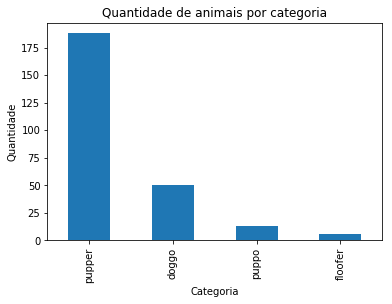

In [158]:
df_categorized.category.value_counts().plot(kind='bar');
plt.title('Quantidade de animais por categoria');
plt.xlabel('Categoria');
plt.ylabel('Quantidade');

Qual é a média de notas (`rating_numerator`) das categorias?

In [159]:
df_categorized.groupby('category').rating_numerator.agg(['min', 'max', 'mean'])

,min,max,mean
category,,,
doggo,5,14,11.520000
floofer,10,13,11.833333
pupper,3,14,10.484043
puppo,9,13,11.461538


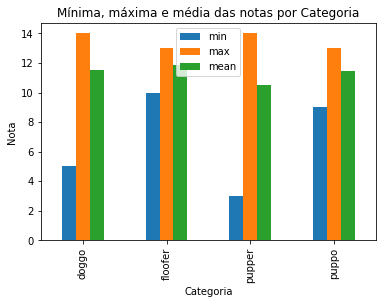

In [160]:
df_categorized.groupby('category').rating_numerator.agg(['min', 'max', 'mean']).plot(kind='bar');
plt.title('Mínima, máxima e média das notas por Categoria');
plt.xlabel('Categoria');
plt.ylabel('Nota');

Qual a média, máximo e minimo da contagem de tweets marcados como **favoritos** (`favorite_count`) entre as categorias?

In [161]:
df_categorized.groupby('category').favorite_count.agg(['min', 'max', 'mean'])

,min,max,mean
category,,,
doggo,2458,163034,19408.920000
floofer,2152,31685,10981.666667
pupper,661,121093,6033.872340
puppo,3093,139348,22861.538462


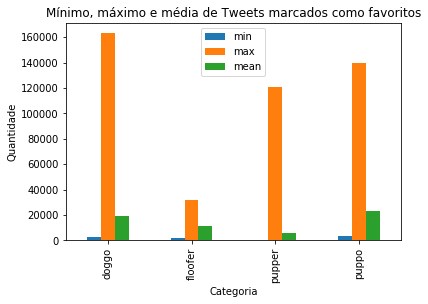

In [162]:
df_categorized.groupby('category').favorite_count.agg(['min', 'max', 'mean']).plot(kind='bar');
plt.title('Mínimo, máximo e média de Tweets marcados como favoritos');
plt.xlabel('Categoria');
plt.ylabel('Quantidade');

In [163]:
df_twitter_master.groupby('category').retweet_count.agg(['min', 'max', 'mean'])

,min,max,mean
category,,,
doggo,675,82905,7675.860000
floofer,465,17234,4813.833333
pupper,96,35138,2004.739362
puppo,658,47253,7113.769231


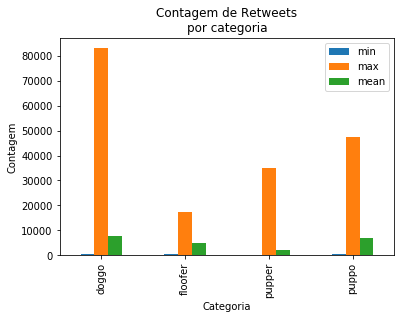

In [164]:
df_twitter_master.groupby('category').retweet_count.agg(['min', 'max', 'mean']).plot(kind='bar');
plt.title('Contagem de Retweets\npor categoria');
plt.xlabel('Categoria');
plt.ylabel('Contagem');

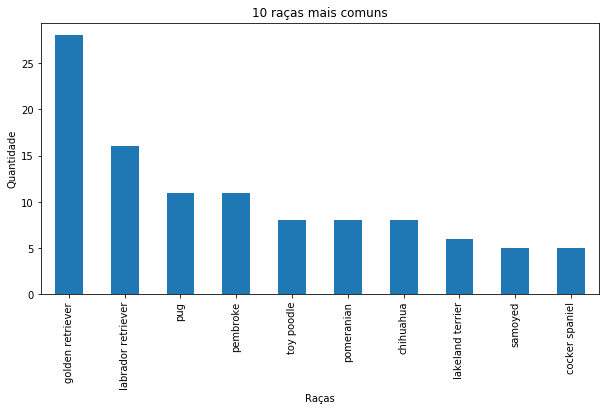

In [165]:
df_categorized.prediction_breed.value_counts().head(10).plot(kind='bar', figsize=(10, 5));
plt.title('10 raças mais comuns');
plt.xlabel('Raças');
plt.ylabel('Quantidade');

In [166]:
df_categorized.prediction_breed.value_counts().head(10)

golden retriever      28
labrador retriever    16
pug                   11
pembroke              11
toy poodle             8
pomeranian             8
chihuahua              8
lakeland terrier       6
samoyed                5
cocker spaniel         5
Name: prediction_breed, dtype: int64

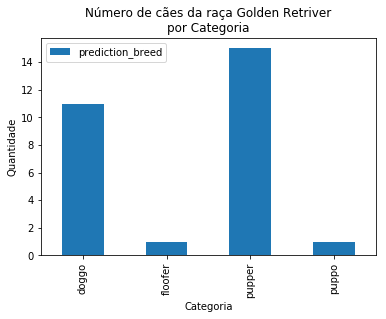

In [167]:
df_categorized.loc[df_twitter_master.prediction_breed == 'golden retriever', ['category', 'prediction_breed']].groupby('category').agg('count').plot(kind='bar');
plt.title('Número de cães da raça Golden Retriver\npor Categoria');
plt.xlabel('Categoria');
plt.ylabel('Quantidade');


In [168]:
df_categorized.loc[df_twitter_master.prediction_breed == 'golden retriever', ['category', 'prediction_breed']].groupby('category').agg('count')

,prediction_breed
category,
doggo,11
floofer,1
pupper,15
puppo,1


In [169]:
df_twitter_master.prediction_breed.value_counts().head(10)

golden retriever      141
labrador retriever     91
chihuahua              81
pembroke               80
pug                    58
toy poodle             49
chow                   43
pomeranian             37
samoyed                34
cocker spaniel         29
Name: prediction_breed, dtype: int64

Text(0, 0.5, 'retweet_count')

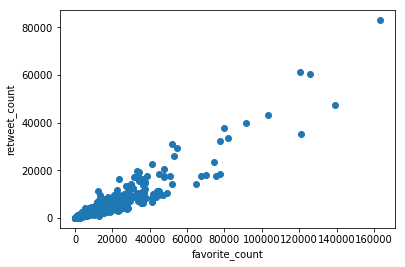

In [170]:
plt.scatter('favorite_count', 'retweet_count', data=df_twitter_master)
plt.xlabel('favorite_count')
plt.ylabel('retweet_count')

# Relatórios

* Data wrangling efforts
* Analyses and visualizations